In [1]:
# Pick up package from parent folder
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import sklearn
from sklearn import metrics
import time

import ordinal
from ordinal import OrderedProbitRanker
from ordinal import OrderedLogitRanker

In [3]:
def fitscore(model, X, y):
    start = time.time()
    model.fit(X, y)
    pred_val = model.predict(X)
    print("time: ", time.time() - start)
    print("score: ", metrics.accuracy_score(pred_val, y))
    print("mse: ", metrics.mean_squared_error(pred_val, y))
    print("mae: ", metrics.mean_absolute_error(pred_val, y))
    pd.Series(pred_val).hist(bins=N_CLASSES)

# Boston prepro

In [4]:
from sklearn.datasets import load_boston, load_diabetes, load_linnerud
from sklearn.preprocessing import KBinsDiscretizer

N_CLASSES = 6

boston = load_boston()
X = boston['data']
y = boston['target']
kbd = KBinsDiscretizer(n_bins=N_CLASSES, encode='ordinal', strategy='kmeans')
y = kbd.fit_transform(y.reshape(-1, 1)).flatten().astype(np.int32)

In [5]:
pd.Series(y).hist(bins=N_CLASSES)

time:  2.2954821586608887
score:  0.7193675889328063
mse:  0.4525691699604743
mae:  0.3300395256916996


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


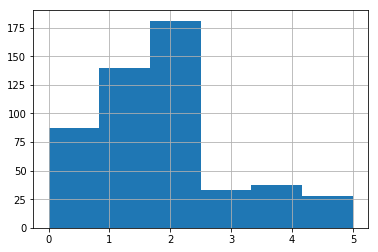

In [6]:
lr = sklearn.linear_model.LogisticRegression(C=9999, solver='lbfgs', multi_class='auto', max_iter=10000)
fitscore(lr, X, y)

time:  3.4724714756011963
score:  0.6600790513833992
mse:  0.4624505928853755
mae:  0.37549407114624506


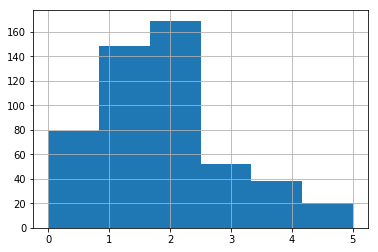

In [7]:
lat = OrderedLogitRanker(alpha=1, verbose=1, variant='at')
fitscore(lat, X, y)

time:  2.9459104537963867
score:  0.6719367588932806
mse:  0.4624505928853755
mae:  0.3675889328063241


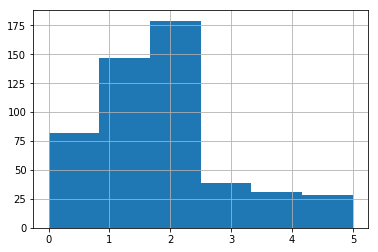

In [8]:
lit = OrderedLogitRanker(alpha=1, verbose=1, variant='it')
fitscore(lit, X, y)

time:  2.6344707012176514
score:  0.6442687747035574
mse:  0.4525691699604743
mae:  0.38537549407114624


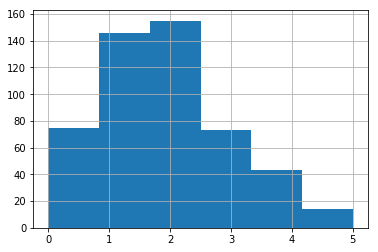

In [9]:
lse = OrderedLogitRanker(alpha=1, verbose=1, variant='se')
fitscore(lse, X, y)

C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:518: RuntimeWarning: Method nelder-mead cannot handle constraints nor bounds.
  RuntimeWarning)
E:\Ordinal-master\ordinal\probit.py:242: OptimizeWarning: Unknown solver options: maxfun
  options={"disp":self.verbose, 'maxiter':50000, "maxfun":150000})


time:  3.5839500427246094
score:  0.525691699604743
mse:  1.0019762845849802
mae:  0.6264822134387352


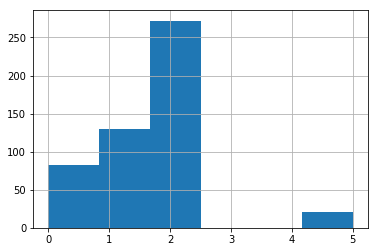

In [23]:
opr = OrderedProbitRanker(method='nelder-mead', use_grad=False)
fitscore(opr, X, y)

# Diabetes Prepro

In [11]:
diabetes = load_diabetes()
Xd = diabetes['data']
yd = diabetes['target']
kbd = KBinsDiscretizer(n_bins=N_CLASSES, encode='ordinal', strategy='kmeans')
yd = kbd.fit_transform(yd.reshape(-1, 1)).flatten().astype(np.int32)

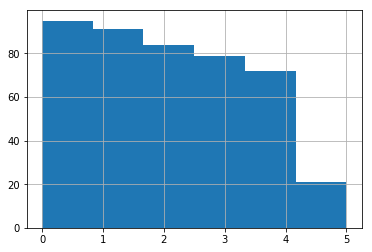

In [12]:
pd.Series(yd).hist(bins=N_CLASSES)

time:  0.1949481964111328
score:  0.4230769230769231
mse:  1.5271493212669682
mae:  0.8529411764705882


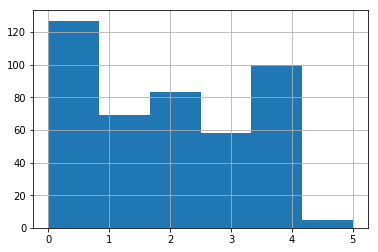

In [13]:
lr = sklearn.linear_model.LogisticRegression(C=9999, solver='lbfgs', multi_class='auto', max_iter=10000)
fitscore(lr, Xd, yd)

time:  0.038997650146484375
score:  0.2986425339366516
mse:  1.3167420814479638
mae:  0.9004524886877828


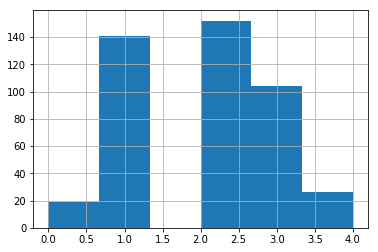

In [14]:
lat = OrderedLogitRanker(alpha=1, verbose=1, variant='at')
fitscore(lat, Xd, yd)

time:  0.02700042724609375
score:  0.3733031674208145
mse:  1.6877828054298643
mae:  0.9366515837104072


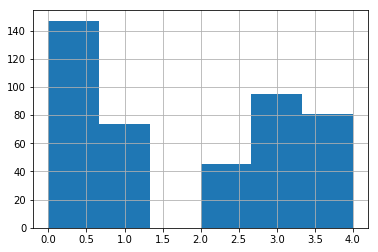

In [15]:
lit = OrderedLogitRanker(alpha=1, verbose=1, variant='it')
fitscore(lit, Xd, yd)

time:  0.03999638557434082
score:  0.28054298642533937
mse:  1.3574660633484164
mae:  0.9230769230769231


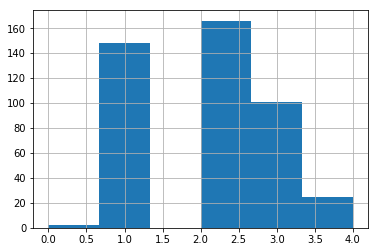

In [16]:
lse = OrderedLogitRanker(alpha=1, verbose=1, variant='se')
fitscore(lse, Xd, yd)

time:  1.564086675643921
score:  0.3506787330316742
mse:  1.4434389140271493
mae:  0.8823529411764706


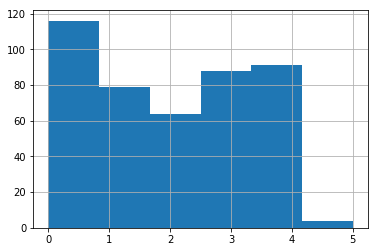

In [17]:
opr = OrderedProbitRanker(method='L-BFGS-B', use_grad=False)
fitscore(opr, Xd, yd)

# Testing

In [26]:
X = Xd
y = yd

opr = OrderedProbitRanker(method='L-BFGS-B', use_grad=False)
start = time.time()
opr.fit(X, y)
pred_val = opr.predict(X)
print("time: ", time.time() - start)
print("score: ", metrics.accuracy_score(pred_val, y))
print("cuts: ", opr.cuts_)

time:  2.201390266418457
score:  0.3506787330316742
cuts:  [-1.17651806 -0.3330453   0.38762989  1.19861104  2.47597302]


In [75]:
ymasks = np.array([np.array(y == c_) for c_ in opr.classes_])

n_class = len(opr.classes_)
n_cuts = len(opr.classes_) - 1
n_samples = X.shape[0]
n_features = X.shape[1]

xb = X @ opr.coef_
# cdf up to cutpoints
cdf_areas = [norm.cdf(ct - xb) for ct in opr.cuts_]
# last cdf area is from last cutpoint on
cdf_areas.append(cdf_areas[-1])
cdf_areas = np.array(cdf_areas)
# pdf areas between cutpoints = cdf[i] - cdf[i-1]
pdf_areas = np.empty_like(ymasks, dtype='float')
# first is cdf[cut_0] - 0
pdf_areas[0] = cdf_areas[0]
# last is 1 - cdf[last_cut]
pdf_areas[-1] = 1 - cdf_areas[-1]
# middle cuts are cdf area between each
for i in range(1, n_cuts):
    pdf_areas[i] = cdf_areas[i] - cdf_areas[i-1]
res = np.zeros(n_samples)
for i in range(len(ymasks)):
    res += (ymasks[i] * pdf_areas[i])

res = np.sum(np.log(res))
res

-610.275337759123

In [77]:
pd.DataFrame(pdf_areas)

,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,441
0,0.014257,0.685557,0.050055,0.065961,0.226139,0.404689,0.619628,0.272612,0.090087,0.010321,...,0.006760,0.730568,0.208806,0.271143,0.781028,0.024427,0.373713,0.266596,0.010278,0.785261
1,0.074785,0.222150,0.161554,0.187675,0.310452,0.321805,0.254883,0.321657,0.219596,0.060326,...,0.045181,0.197012,0.304318,0.321408,0.166263,0.105573,0.325256,0.320598,0.060157,0.163563
2,0.176614,0.071985,0.256440,0.269324,0.255164,0.180575,0.094653,0.237006,0.278910,0.155887,...,0.130621,0.057742,0.261325,0.237606,0.043062,0.212475,0.193934,0.239456,0.155627,0.041895
3,0.307720,0.018179,0.299502,0.284497,0.156005,0.076506,0.027150,0.130378,0.261051,0.297656,...,0.279729,0.013281,0.166708,0.131125,0.008832,0.314883,0.087066,0.133463,0.297503,0.008506
4,0.354800,0.002111,0.210137,0.176603,0.050380,0.016102,0.003647,0.037194,0.139975,0.385367,...,0.419244,0.001387,0.056601,0.037547,0.000809,0.296419,0.019598,0.038663,0.385736,0.000770
5,0.071824,0.000018,0.022313,0.015939,0.001861,0.000323,0.000038,0.001154,0.010381,0.090442,...,0.118464,0.000010,0.002242,0.001171,0.000005,0.046224,0.000434,0.001225,0.090698,0.000004


In [81]:
# expression x[:, None] - xb outputs shape (n_class - 1, n_samples)
cdf_areas = norm.cdf(np.hstack((-np.inf, opr.cuts_, np.inf))[:, None] - xb)
dist_areas = np.diff(cdf_areas, axis=0)

In [86]:
np.sum(ymasks * dist_areas, axis=0).shape

(442,)

In [20]:
L = np.zeros((n_class - 1, n_class - 1))
L[np.tril_indices(n_class-1)] = 1.

loss_fd_weights = np.ones((n_class, n_class - 1))

In [21]:
(L @ opr.cuts_)[:, None]

array([[ 0.05816366],
       [ 1.5996726 ],
       [ 4.498886  ],
       [ 8.04202959],
       [12.24565473]])

In [22]:
opr.cuts_

array([0.05816366, 1.54150895, 2.89921339, 3.54314359, 4.20362514])